In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

In [2]:
train_data = pd.read_csv("HW2_training.csv")
test_data = pd.read_csv("HW2_testing.csv")

In [3]:
class OneHotEncoder:
    def __init__(self, data: pd.DataFrame, groupby_column: str):
        self.data = data
        self.groupby_column = groupby_column
        self.grouped_data = self.data.groupby(self.groupby_column)
        self.count = {team: len(group) for team, group in self.grouped_data}
        self.data_vec = self.data.drop(columns=self.groupby_column).to_numpy()
        self.labels = sorted(self.count.keys())
        self.label_to_index = {label: i for i, label in enumerate(self.labels)}
        self.class_list = [
            self.label_to_index[label]
            for label in self.data[self.groupby_column].values
        ]
        self.one_hot_encoded = np.eye(len(self.labels))[self.class_list]

    def plot(self):
        plt.clf()
        scatter = plt.scatter(
            self.data["Offensive"],
            self.data["Defensive"],
            c=np.argmax(self.one_hot_encoded, axis=1),
            alpha=0.5,
        )
        plt.colorbar(
            scatter,
            ticks=np.arange(len(self.labels)),
            label="Team",
            format=lambda x, pos: self.labels[int(x)],
        )
        # plt.colorbar(label="Team")
        plt.xlabel("Offensive")
        plt.ylabel("Defensive")
        plt.grid()
        plt.show()

In [4]:
class GenerativeModel(OneHotEncoder):
    def __init__(self, data: pd.DataFrame, groupby_column: str):
        super().__init__(data, groupby_column)
        self.mean_dict = self.grouped_data.mean().to_dict(orient="index")
        for key, value in self.mean_dict.items():
            self.mean_dict[key] = list(value.values())
        self.group_num_list = list(self.count.keys())
        self.pi_dict = dict(
            zip(
                self.count.keys(),
                list(np.array(list(self.count.values())) / sum(self.count.values())),
            )
        )
        self.cov_matrix = self.covariance_matrices()
        self.pi_mean = [
            (self.pi_dict[group], self.mean_dict[group])
            for group in self.group_num_list
        ]
        
    def covariance_matrices(self):
        def build_group_matrix(group_of_matrix, group_mean, coef):
            matrix_term_list = [item_vec - group_mean for item_vec in group_of_matrix]
            matrix_term_list = [
                item.reshape(-1, 1) @ [item] for item in matrix_term_list
            ]
            return (
                coef * (1.0 / len(matrix_term_list)) * np.sum(matrix_term_list, axis=0)
            )

        result_dict = {
            i: build_group_matrix(
                group_of_matrix=self.grouped_data.get_group(i)
                .drop(columns=self.groupby_column)
                .to_numpy(),
                group_mean=self.mean_dict[i],
                coef=self.pi_dict[i],
            )
            for i in self.count.keys()
        }
        return np.sum(list(result_dict.values()), axis=0)

    @staticmethod
    def multivariate_normal_pdf(x, mean, cov_matrix):
        k = len(mean)
        constant_term = 1 / (
            (2 * np.pi) ** (k / 2) * np.sqrt(np.linalg.det(cov_matrix))
        )
        exponent_term = np.exp(
            -0.5 * np.dot(np.dot((x - mean), np.linalg.inv(cov_matrix)), (x - mean).T)
        )
        return constant_term * exponent_term
    
    def joint_pdf(self, x):
        return np.array(
            [
                pi_item * self.multivariate_normal_pdf(x, mean_item, self.cov_matrix)
                for pi_item, mean_item in self.pi_mean
            ]
        )

    def prediction(self, x):
        if isinstance(x, str):
            x = self.label_to_index[x]
        result_vector = (joint_pdf_res := self.joint_pdf(x=x)) / np.sum(joint_pdf_res)
        return self.group_num_list[np.argmax(result_vector)]

    def plot_decision_boundaries(self, resolution=1000):
        x_min, x_max = (
            self.data["Offensive"].min() - 1,
            self.data["Offensive"].max() + 1,
        )
        y_min, y_max = (
            self.data["Defensive"].min() - 1,
            self.data["Defensive"].max() + 1,
        )
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution)
        )
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        predictions = np.array([self.prediction(point) for point in grid_points])
        predictions_indices = np.array(
            [self.label_to_index[label] for label in predictions]
        )
        predictions_indices = predictions_indices.reshape(xx.shape)

        plt.figure(figsize=(10, 8))
        plt.contourf(
            xx, yy, predictions_indices, alpha=0.5
        )

        cb = plt.colorbar(ticks=np.arange(len(self.labels)), label="Team")
        cb.ax.set_yticklabels(self.labels)

        plt.xlabel("Offensive")
        plt.ylabel("Defensive")
        plt.title("Decision Boundaries")
        plt.grid(True)
        plt.show()

In [5]:
class DiscriminativeModel(OneHotEncoder):
    def __init__(self, data: pd.DataFrame, groupby_column: str):
        super().__init__(data, groupby_column)
        self.group_num_list = list(self.count.keys())
        self.phi_matrix = self.build_basis_function(x=self.data_vec)
        self.K = len(self.group_num_list)
        self.M = self.phi_matrix.shape[1]
        self.weights = np.zeros((self.K, self.M))

    def build_basis_function(self, x):
        return np.hstack((np.ones((x.shape[0], 1)), x))

    def softmax(self, x):
        exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    def fit(self, method='gradient_descent', learning_rate=0.1, max_iter=1000000, tol=1e-5):
        X = self.phi_matrix
        Y = self.one_hot_encoded

        cache = np.zeros_like(self.weights)
        error_list = []
        for _ in range(max_iter):
            scores = np.dot(X, self.weights.T)
            probs = self.softmax(scores)
            
            error = -np.sum(Y * np.log(probs))
            error_list.append(error)
            
            if len(error_list) > 1 and (abs(error_list[-2] - error_list[-1]) <= tol):
                print(f"Converged at iteration {_+1}")
                break
            
            if method == 'gradient_descent':
                gradient = np.dot((probs - Y).T, X)
                cache += gradient ** 2
                adjusted_gradient = gradient / (np.sqrt(cache) + 1e-8)
                self.weights -= learning_rate * adjusted_gradient

            elif method == 'newton_raphson':
                weight_matrix = np.diag(np.sum(probs * (1 - probs), axis=1))

                hessian = np.dot(X.T, np.dot(weight_matrix, X))

                gradient = np.dot(X.T, (probs - Y))

                update_direction = np.linalg.solve(hessian, gradient)

                self.weights -= update_direction.T

            else:
                raise ValueError("Invalid method specified. Choose either 'gradient_descent' or 'newton_raphson'.")
            
            if np.linalg.norm(gradient) < tol:
                print(f"Converged at iteration {_+1}")
                break
            
        return error_list
            
    def prediction(self,x):
        X = self.build_basis_function(x)
        scores = np.dot(X, self.weights.T)
        return np.argmax(scores, axis=1)
    
    def plot_decision_boundaries(self, resolution=1000):
        x_min, x_max = (
            self.data["Offensive"].min() - 1,
            self.data["Offensive"].max() + 1,
        )
        y_min, y_max = (
            self.data["Defensive"].min() - 1,
            self.data["Defensive"].max() + 1,
        )
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution)
        )
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        predict = self.prediction(grid_points)
        
        predictions = np.array([self.group_num_list[i] for i in predict])
        predictions_indices = np.array(
            [self.label_to_index[label] for label in predictions]
        )
        predictions_indices = predictions_indices.reshape(xx.shape)

        plt.figure(figsize=(10, 8))
        plt.contourf(
            xx, yy, predictions_indices, alpha=0.5
        )

        cb = plt.colorbar(ticks=np.arange(len(self.labels)), label="Team")
        cb.ax.set_yticklabels(self.labels)

        plt.xlabel("Offensive")
        plt.ylabel("Defensive")
        plt.title("Decision Boundaries")
        plt.grid(True)
        plt.show()

In [6]:
def compute_confusion_matrix(true_labels, predicted_labels, num_classes):
    unique_labels = sorted(set(true_labels) | set(predicted_labels))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for true_label, pred_label in zip(true_labels, predicted_labels):
        true_label_idx = label_to_index[true_label]
        pred_label_idx = label_to_index[pred_label]
        confusion_matrix[true_label_idx][pred_label_idx] += 1

    return confusion_matrix

def compute_accuracy(confusion_matrix):
    correct_predictions = np.diag(confusion_matrix).sum()
    total_predictions = confusion_matrix.sum()
    return 100 * correct_predictions / total_predictions

# **Part I**

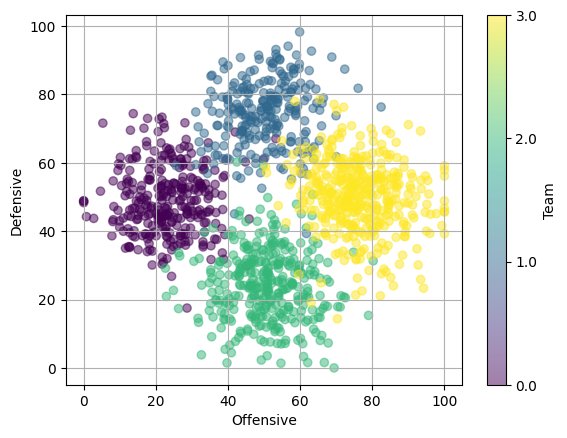

In [7]:
encoder_train = OneHotEncoder(train_data, "Team")
encoder_train.plot()

Generative Model

In [8]:
generative_model = GenerativeModel(train_data, "Team")

Conditional probability distributions

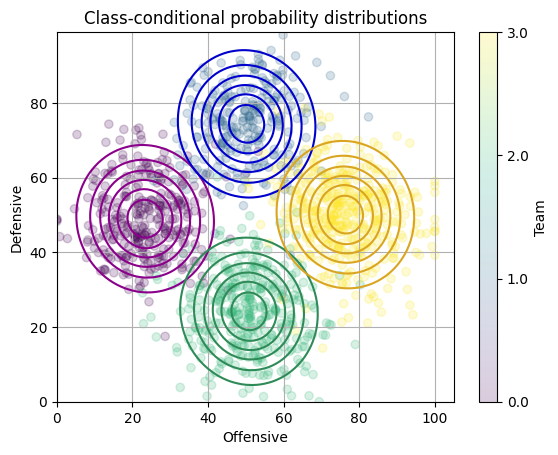

In [9]:
def plot_contour(mean, cov_matrix, color='b', **kwargs):
        x, y = np.mgrid[0:100:1, 0:100:1]
        pos = np.dstack((x, y))
        plt.contour(x, y, multivariate_normal.pdf(pos, mean=mean, cov=cov_matrix), colors=color, **kwargs)

def plot(data, one_hot_encoded, labels, mean_dict, cov_matrix):
    plt.clf()
    scatter = plt.scatter(
        data["Offensive"],
        data["Defensive"],
        c=np.argmax(one_hot_encoded, axis=1),
        alpha=0.2,
    )
    plt.colorbar(
        scatter,
        ticks=np.arange(len(labels)),
        label="Team",
        format=lambda x, pos: labels[int(x)],
    )
    colors = ['darkmagenta', 'mediumblue', 'seagreen', 'goldenrod']

    for i, label in enumerate(labels):
        mean = mean_dict[i]
        plot_contour(mean, cov_matrix, color=colors[i])
    plt.title('Class-conditional probability distributions')
    plt.xlabel("Offensive")
    plt.ylabel("Defensive")
    plt.grid()
    plt.show()

data = generative_model.data
one_hot_encoded = generative_model.one_hot_encoded
labels = generative_model.labels
mean_dict = generative_model.mean_dict
cov_matrix = generative_model.cov_matrix
plot(data, one_hot_encoded, labels, mean_dict, cov_matrix)

Decision boundaries

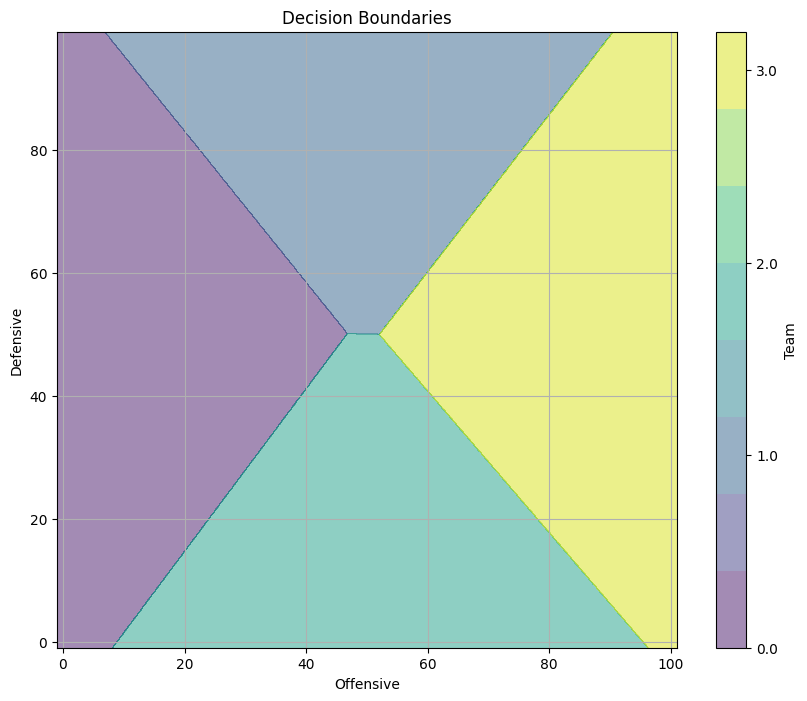

In [10]:
generative_model.plot_decision_boundaries()

Confussion matrix

In [11]:
predicted_train_gm = np.array(
    [
        generative_model.prediction(row)
        for row in train_data[["Offensive", "Defensive"]].values
    ]
)
true_labels_train = train_data["Team"].values

predicted_test_gm = np.array(
    [
        generative_model.prediction(row)
        for row in test_data[["Offensive", "Defensive"]].values
    ]
)
true_labels_test = test_data["Team"].values

confusion_matrix_train_gm = compute_confusion_matrix(
    true_labels_train, predicted_train_gm, len(generative_model.group_num_list)
)
confusion_matrix_test_gm = compute_confusion_matrix(
    true_labels_test, predicted_test_gm, len(generative_model.group_num_list)
)

accuracy_train_gm = compute_accuracy(confusion_matrix_train_gm)
accuracy_test_gm = compute_accuracy(confusion_matrix_test_gm)

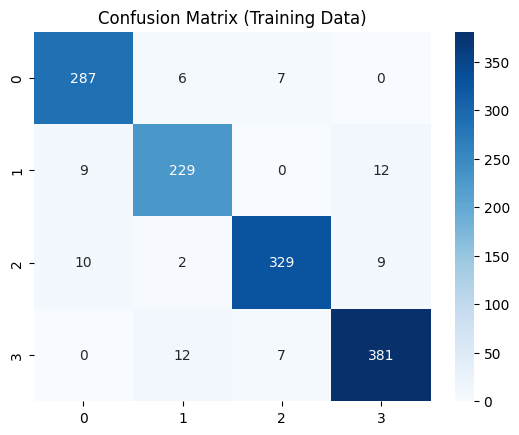

Accuracy (Training Data): 94.3076923076923


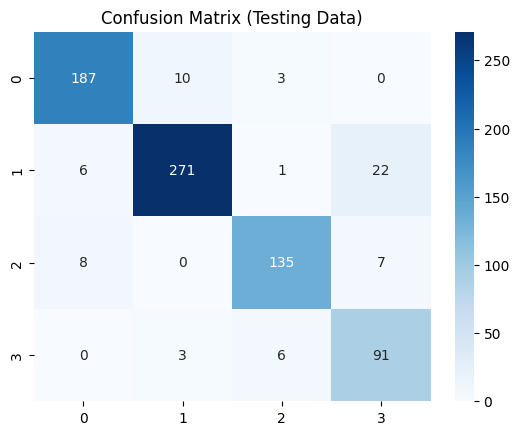

Accuracy (Testing Data): 91.2


In [12]:
plt.clf()
plt.title(f'Confusion Matrix (Training Data)')
sns.heatmap(confusion_matrix_train_gm, annot=True, fmt=".0f", cmap='Blues')
plt.show()
print("Accuracy (Training Data):", accuracy_train_gm)

plt.clf()
plt.title(f'Confusion Matrix (Testing Data)')
sns.heatmap(confusion_matrix_test_gm, annot=True, fmt=".0f", cmap='Blues')
plt.show()
print("Accuracy (Testing Data):", accuracy_test_gm)

Discriminative Model

In [13]:
discriminative_model_gd= DiscriminativeModel(train_data, "Team")
discriminative_model_nr= DiscriminativeModel(train_data, "Team")

Converged at iteration 144410


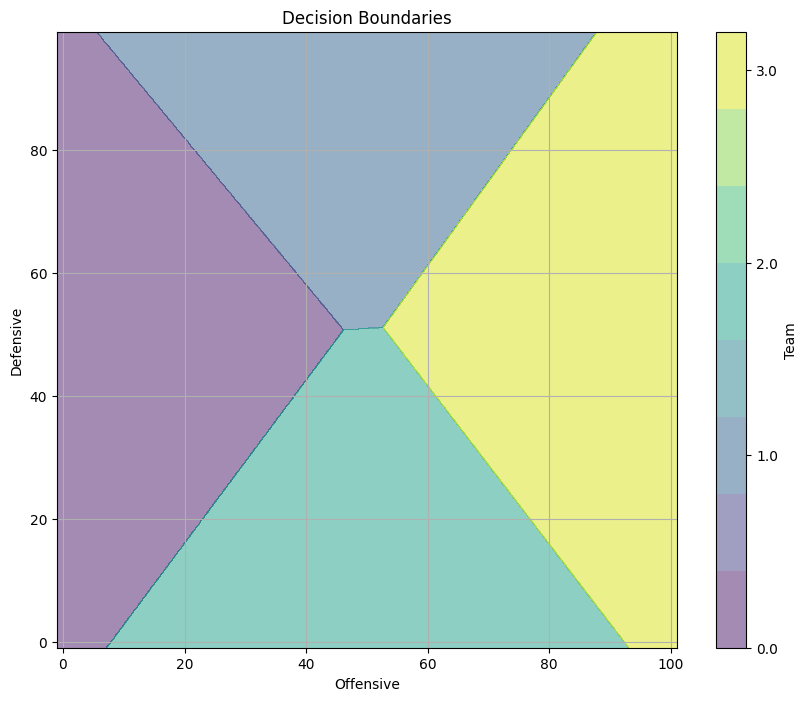

In [14]:
error_list_gd = discriminative_model_gd.fit(method='gradient_descent')
discriminative_model_gd.plot_decision_boundaries()

Converged at iteration 188


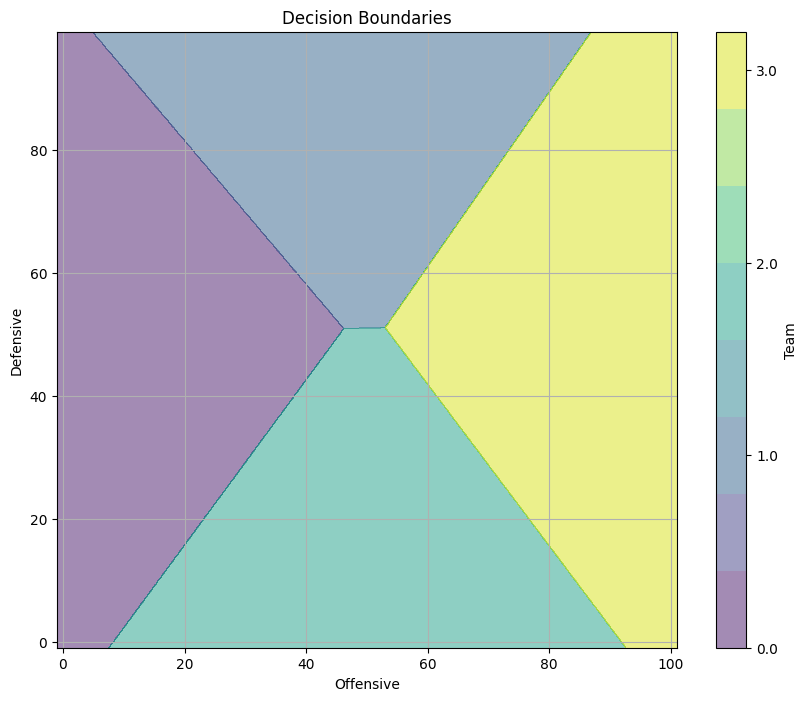

In [15]:
error_list_nr = discriminative_model_nr.fit(method='newton_raphson')
discriminative_model_nr.plot_decision_boundaries()

Confussion Matrix

In [16]:
predicted_train_dm_gd = discriminative_model_gd.prediction(train_data[["Offensive", "Defensive"]].values)
predicted_test_dm_gd = discriminative_model_gd.prediction(test_data[["Offensive", "Defensive"]].values)

confusion_matrix_train_dm_gd = compute_confusion_matrix(
    true_labels_train, predicted_train_dm_gd, len(discriminative_model_gd.group_num_list)
)
confusion_matrix_test_dm_gd = compute_confusion_matrix(
    true_labels_test, predicted_test_dm_gd, len(discriminative_model_gd.group_num_list)
)

accuracy_train_dm_gd = compute_accuracy(confusion_matrix_train_dm_gd)
accuracy_test_dm_gd = compute_accuracy(confusion_matrix_test_dm_gd)

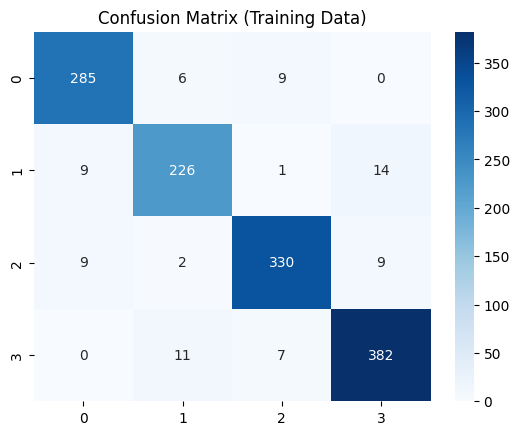

Accuracy (Training Data): 94.07692307692308


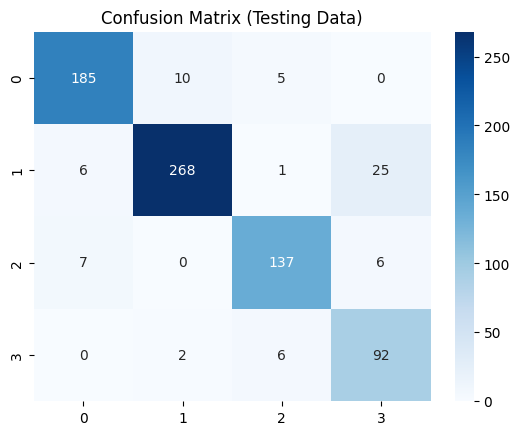

Accuracy (Testing Data): 90.93333333333334


In [17]:
plt.clf()
plt.title(f'Confusion Matrix (Training Data)')
sns.heatmap(confusion_matrix_train_dm_gd, annot=True, fmt=".0f", cmap='Blues')
plt.show()
print("Accuracy (Training Data):", accuracy_train_dm_gd)

plt.clf()
plt.title(f'Confusion Matrix (Testing Data)')
sns.heatmap(confusion_matrix_test_dm_gd, annot=True, fmt=".0f", cmap='Blues')
plt.show()
print("Accuracy (Testing Data):", accuracy_test_dm_gd)

In [18]:
predicted_train_dm_nr = discriminative_model_nr.prediction(train_data[["Offensive", "Defensive"]].values)
predicted_test_dm_nr = discriminative_model_nr.prediction(test_data[["Offensive", "Defensive"]].values)

confusion_matrix_train_dm_nr = compute_confusion_matrix(
    true_labels_train, predicted_train_dm_nr, len(discriminative_model_nr.group_num_list)
)
confusion_matrix_test_dm_nr = compute_confusion_matrix(
    true_labels_test, predicted_test_dm_nr, len(discriminative_model_nr.group_num_list)
)

accuracy_train_dm_nr = compute_accuracy(confusion_matrix_train_dm_nr)
accuracy_test_dm_nr = compute_accuracy(confusion_matrix_test_dm_nr)

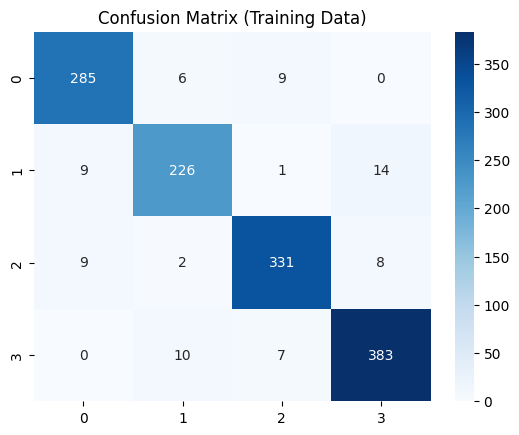

Accuracy (Training Data): 94.23076923076923


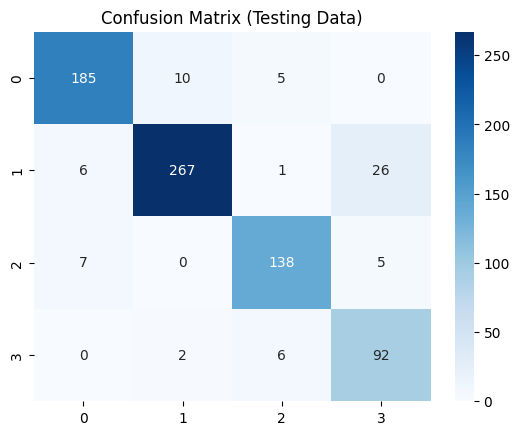

Accuracy (Testing Data): 90.93333333333334


In [19]:
plt.clf()
plt.title(f'Confusion Matrix (Training Data)')
sns.heatmap(confusion_matrix_train_dm_nr, annot=True, fmt=".0f", cmap='Blues')
plt.show()
print("Accuracy (Training Data):", accuracy_train_dm_nr)

plt.clf()
plt.title(f'Confusion Matrix (Testing Data)')
sns.heatmap(confusion_matrix_test_dm_nr, annot=True, fmt=".0f", cmap='Blues')
plt.show()
print("Accuracy (Testing Data):", accuracy_test_dm_nr)

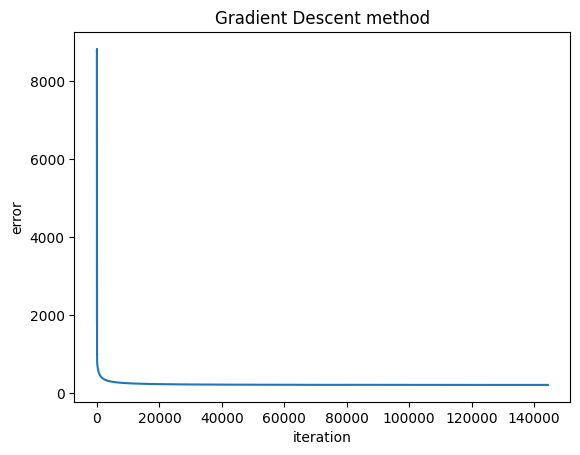

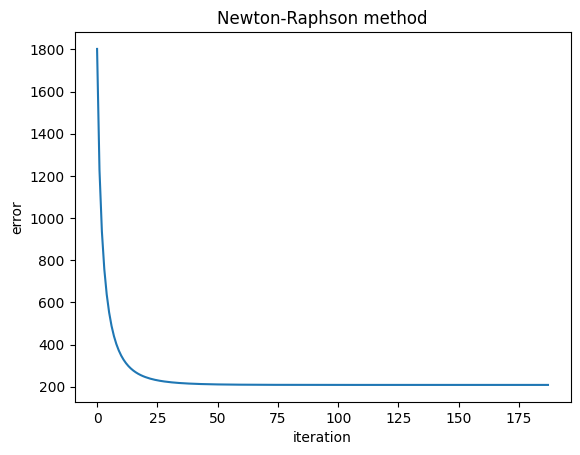

In [20]:
plt.clf()
pd.Series(error_list_gd).plot()
plt.title("Gradient Descent method")
plt.ylabel("error")
plt.xlabel("iteration")
plt.show()

plt.clf()
pd.Series(error_list_nr).plot()
plt.title("Newton-Raphson method")
plt.ylabel("error")
plt.xlabel("iteration")
plt.show()

# **PART II**

In [21]:
train_data_2 = pd.read_csv("HW2_training.csv")
test_data_2 = pd.read_csv("HW2_testing.csv")

In [22]:
class_mapping = {0: "A", 1: "B", 2: "C", 3: "A"}
train_data_2["Team"] = train_data_2["Team"].map(class_mapping)
test_data_2["Team"] = test_data_2["Team"].map(class_mapping)

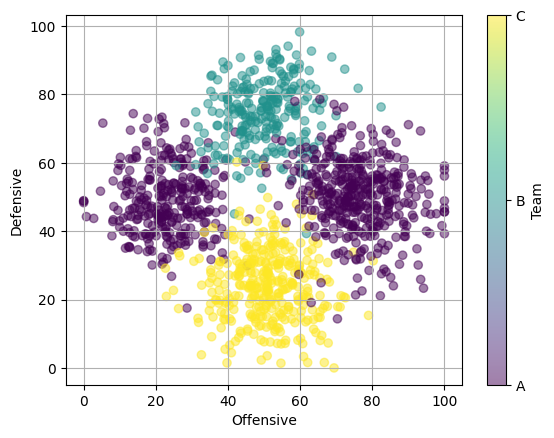

In [23]:
encoder_train_2 = OneHotEncoder(train_data_2, "Team")
encoder_train_2.plot()

Generative Model

In [24]:
generative_model_2 = GenerativeModel(train_data_2, "Team")

Conditional probability distributions

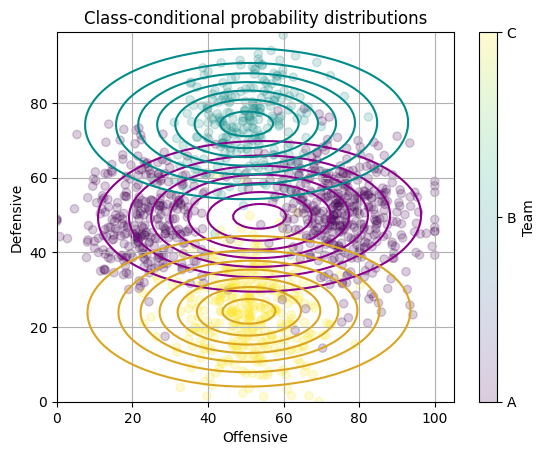

In [25]:
def plot_contour(mean, cov_matrix, color='b', **kwargs):
        x, y = np.mgrid[0:100:1, 0:100:1]
        pos = np.dstack((x, y))
        plt.contour(x, y, multivariate_normal.pdf(pos, mean=mean, cov=cov_matrix), colors=color, **kwargs)
        
def plot(data, one_hot_encoded, labels, mean_dict, cov_matrix):
    plt.clf()
    scatter = plt.scatter(
        data["Offensive"],
        data["Defensive"],
        c=np.argmax(one_hot_encoded, axis=1),
        alpha=0.2,
    )
    plt.colorbar(
        scatter,
        ticks=np.arange(len(labels)),
        label="Team",
        format=lambda x, pos: labels[int(x)],
    )
    colors = ['darkmagenta', 'darkcyan', 'goldenrod']

    for i, label in enumerate(labels):
        mean = mean_dict[label]
        plot_contour(mean, cov_matrix, color=colors[i])
    plt.title('Class-conditional probability distributions')
    plt.xlabel("Offensive")
    plt.ylabel("Defensive")
    plt.grid()
    plt.show()

data = generative_model_2.data
one_hot_encoded = generative_model_2.one_hot_encoded
labels = generative_model_2.labels
mean_dict = generative_model_2.mean_dict
cov_matrix = generative_model_2.cov_matrix
plot(data, one_hot_encoded, labels, mean_dict, cov_matrix)

Decision Boundary

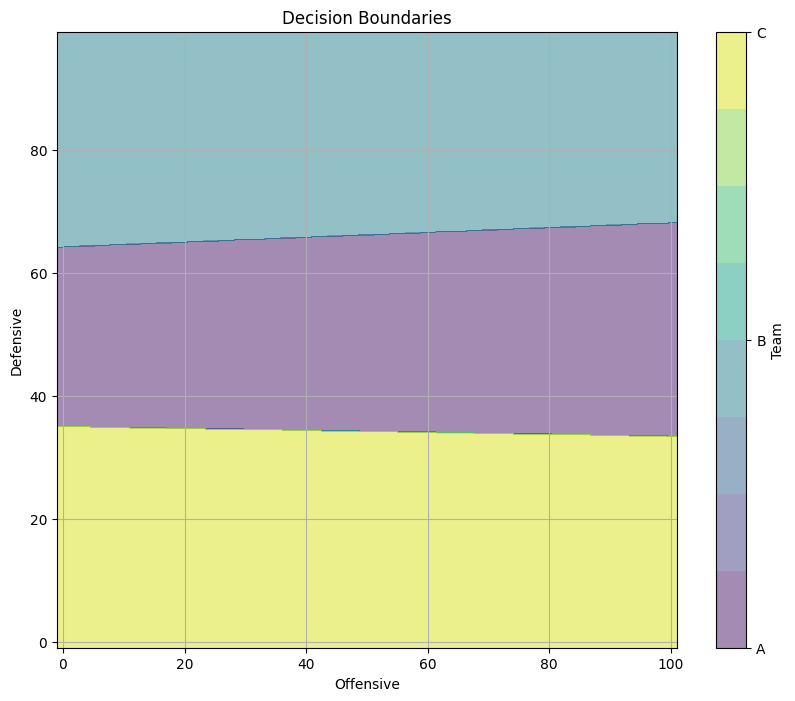

In [26]:
generative_model_2.plot_decision_boundaries()

Confusion Matrix

In [27]:
new_class = ['A', 'B', 'C']

predicted_train_gm_2 = np.array(
    [
        generative_model_2.prediction(row)
        for row in train_data_2[["Offensive", "Defensive"]].values
    ]
)
true_labels_train_2 = train_data_2["Team"].to_numpy()

predicted_test_gm_2 = np.array(
    [
        generative_model_2.prediction(row)
        for row in test_data_2[["Offensive", "Defensive"]].values
    ]
)
true_labels_test_2 = test_data_2["Team"].to_numpy()

confusion_matrix_train_gm_2 = compute_confusion_matrix(
    true_labels_train_2, predicted_train_gm_2, len(generative_model_2.group_num_list)
)
confusion_matrix_test_gm_2 = compute_confusion_matrix(
    true_labels_test_2, predicted_test_gm_2, len(generative_model_2.group_num_list)
)

accuracy_train_gm_2 = compute_accuracy(confusion_matrix_train_gm_2)
accuracy_test_gm_2 = compute_accuracy(confusion_matrix_test_gm_2)

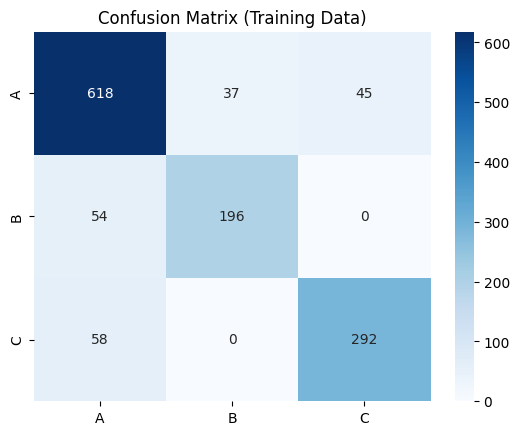

Accuracy (Training Data): 85.07692307692308


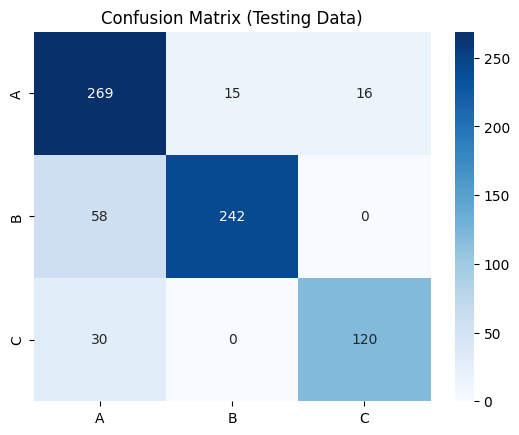

Accuracy (Testing Data): 84.13333333333334


In [28]:
plt.clf()
plt.title(f'Confusion Matrix (Training Data)')
sns.heatmap(confusion_matrix_train_gm_2, annot=True, fmt=".0f", xticklabels=new_class, yticklabels=new_class, cmap='Blues')
plt.show()
print("Accuracy (Training Data):", accuracy_train_gm_2)

plt.clf()
plt.title(f'Confusion Matrix (Testing Data)')
sns.heatmap(confusion_matrix_test_gm_2, annot=True, fmt=".0f", xticklabels=new_class, yticklabels=new_class, cmap='Blues')
plt.show()
print("Accuracy (Testing Data):", accuracy_test_gm_2)

In [29]:
discriminative_model_gd_2 = DiscriminativeModel(train_data_2, "Team")
discriminative_model_nr_2 = DiscriminativeModel(train_data_2, "Team")

Converged at iteration 69323


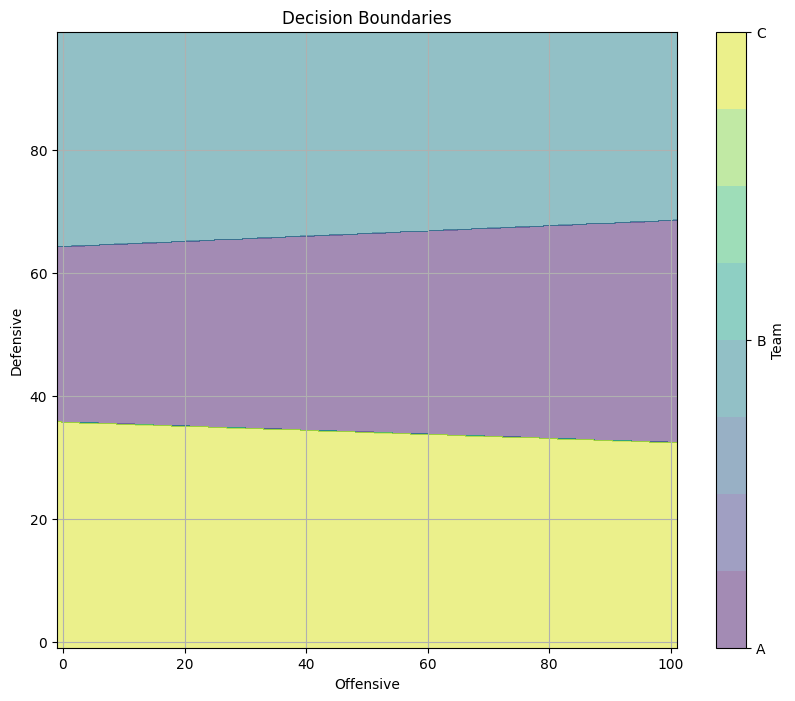

In [30]:
error_list_gd_2 = discriminative_model_gd_2.fit(method='gradient_descent')
discriminative_model_gd_2.plot_decision_boundaries()

Converged at iteration 182


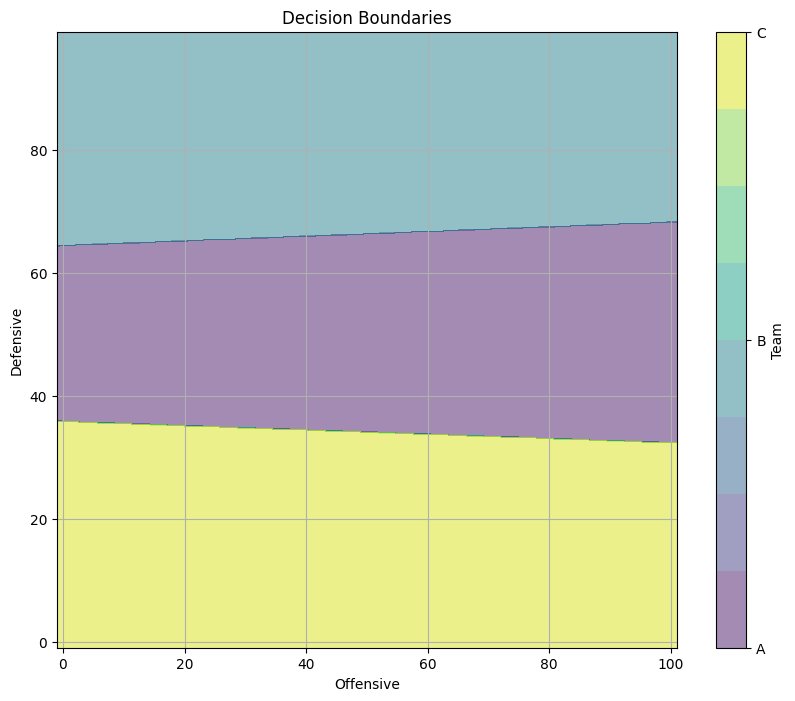

In [31]:
error_list_nr_2 = discriminative_model_nr_2.fit(method='newton_raphson')
discriminative_model_nr_2.plot_decision_boundaries()

In [32]:
predict_train_gd = discriminative_model_gd_2.prediction(train_data_2[["Offensive", "Defensive"]].values)
predict_test_gd = discriminative_model_gd_2.prediction(test_data_2[["Offensive", "Defensive"]].values)
  
predicted_train_dm_gd_2 = np.array([discriminative_model_gd_2.group_num_list[i] for i in predict_train_gd])
predicted_test_dm_gd_2 = np.array([discriminative_model_gd_2.group_num_list[i] for i in predict_test_gd])

confusion_matrix_train_dm_gd_2 = compute_confusion_matrix(
    true_labels_train_2, predicted_train_dm_gd_2, len(discriminative_model_gd_2.group_num_list)
)
confusion_matrix_test_dm_gd_2 = compute_confusion_matrix(
    true_labels_test_2, predicted_test_dm_gd_2, len(discriminative_model_gd_2.group_num_list)
)

accuracy_train_dm_gd_2 = compute_accuracy(confusion_matrix_train_dm_gd_2)
accuracy_test_dm_gd_2 = compute_accuracy(confusion_matrix_test_dm_gd_2)

In [33]:
predict_train_nr = discriminative_model_nr_2.prediction(train_data_2[["Offensive", "Defensive"]].values)
predict_test_nr = discriminative_model_nr_2.prediction(test_data_2[["Offensive", "Defensive"]].values)
  
predicted_train_dm_nr_2 = np.array([discriminative_model_nr_2.group_num_list[i] for i in predict_train_nr])
predicted_test_dm_nr_2 = np.array([discriminative_model_nr_2.group_num_list[i] for i in predict_test_nr])

confusion_matrix_train_dm_nr_2 = compute_confusion_matrix(
    true_labels_train_2, predicted_train_dm_nr_2, len(discriminative_model_nr_2.group_num_list)
)
confusion_matrix_test_dm_nr_2 = compute_confusion_matrix(
    true_labels_test_2, predicted_test_dm_nr_2, len(discriminative_model_nr_2.group_num_list)
)

accuracy_train_dm_nr_2 = compute_accuracy(confusion_matrix_train_dm_nr_2)
accuracy_test_dm_nr_2 = compute_accuracy(confusion_matrix_test_dm_nr_2)

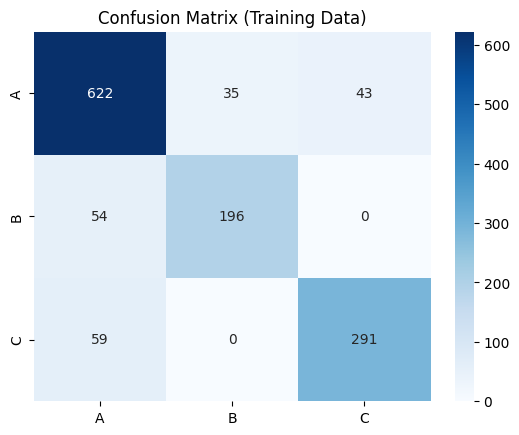

Accuracy (Training Data): 85.3076923076923


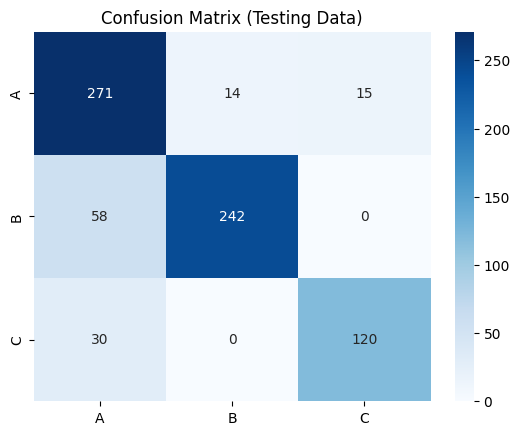

Accuracy (Testing Data): 84.4


In [34]:
plt.clf()
plt.title(f'Confusion Matrix (Training Data)')
sns.heatmap(confusion_matrix_train_dm_gd_2, annot=True, fmt=".0f", xticklabels=new_class, yticklabels=new_class, cmap='Blues')
plt.show()
print("Accuracy (Training Data):", accuracy_train_dm_gd_2)

plt.clf()
plt.title(f'Confusion Matrix (Testing Data)')
sns.heatmap(confusion_matrix_test_dm_gd_2, annot=True, fmt=".0f", xticklabels=new_class, yticklabels=new_class, cmap='Blues')
plt.show()
print("Accuracy (Testing Data):", accuracy_test_dm_gd_2)

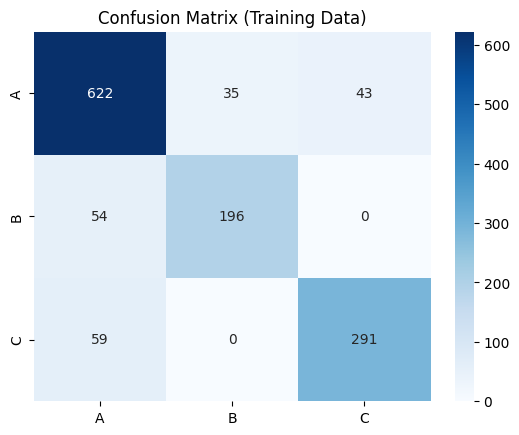

Accuracy (Training Data): 85.3076923076923


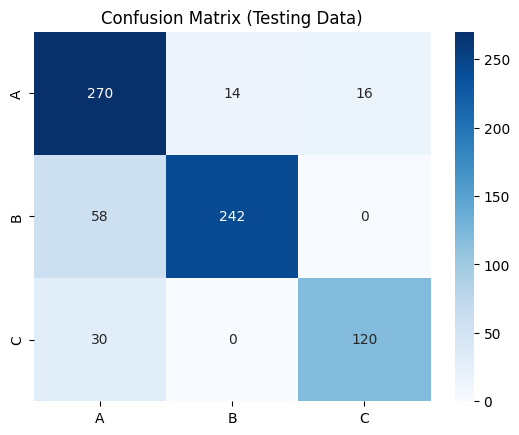

Accuracy (Testing Data): 84.26666666666667


In [35]:
plt.clf()
plt.title(f'Confusion Matrix (Training Data)')
sns.heatmap(confusion_matrix_train_dm_nr_2, annot=True, fmt=".0f", xticklabels=new_class, yticklabels=new_class, cmap='Blues')
plt.show()
print("Accuracy (Training Data):", accuracy_train_dm_nr_2)

plt.clf()
plt.title(f'Confusion Matrix (Testing Data)')
sns.heatmap(confusion_matrix_test_dm_nr_2, annot=True, fmt=".0f", xticklabels=new_class, yticklabels=new_class, cmap='Blues')
plt.show()
print("Accuracy (Testing Data):", accuracy_test_dm_nr_2)

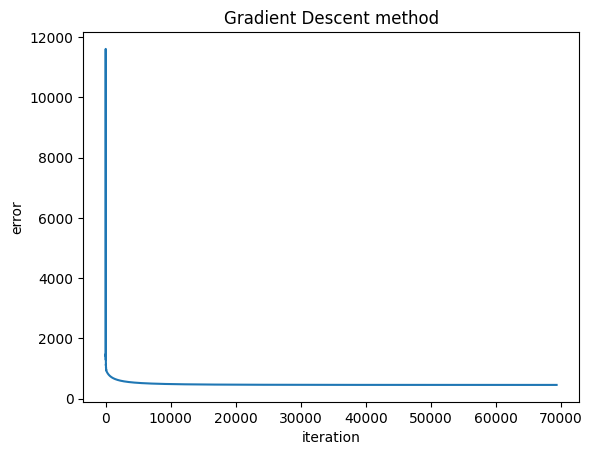

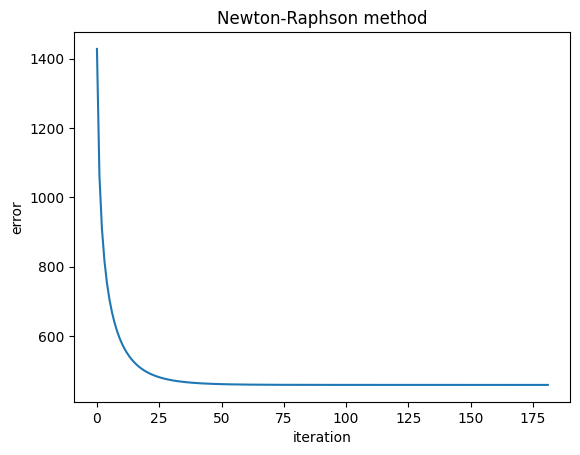

In [36]:
plt.clf()
pd.Series(error_list_gd_2).plot()
plt.title("Gradient Descent method")
plt.ylabel("error")
plt.xlabel("iteration")
plt.show()

plt.clf()
pd.Series(error_list_nr_2).plot()
plt.title("Newton-Raphson method")
plt.ylabel("error")
plt.xlabel("iteration")
plt.show()